## TLDR:
- Traversals can be thought of as "row-by-row" or "column-by-column", where rows represent depth and columns represent breadth
  - Can be visualized as a 2D plane
  - Breadth-first search searches row-by-row, searching all columns in a row before moving onto the next
  - Depth-first search searches column-by-column, searching all rows in a column before moving onto the next
  - Iterative deepening searches in "chunks", either row-by-row or column-by-column for each chunk and each cell inside each chunk
    - Can be used as a hybrid between breadth-first and depth-first searches, but technically doesn't have to be
- Dynamic programming can be used to search directed acyclic graphs with any edge weights in `O(N)`
- Uniform cost search can be used to search graphs of any direction and cyclicity with positive edge weights in `O(N * log2(N))`
  - A* search could be seen as a heuristic version of uniform cost search, such that the target of the search is reached in fewer iterations

*Note: the implementations don't need to make immediate sense. They are there for demonstration of the concepts!*

## Tree Traversal

In [109]:
import random
from matplotlib import pyplot as plt
import math
from queue import PriorityQueue
import numpy as np

class Tree:
  def __init__(self, n):
    self.n = n
    
    edges = []
    for i in range(1, n):
      edges.append((random.randrange(0, i), i))

    adjacency_list = [[] for i in range(n)]
    for a, b in edges:
      adjacency_list[a].append(b)
      adjacency_list[b].append(a)

    self.edges = edges
    self.adjacency_list = adjacency_list
    
    self.__init_depths()
    self.__init_breadths()

  def __init_depths(self):
    self.depths = [0] * self.n

    def recurse(a, parent=-1, depth=0):
      self.depths[a] = depth

      for b in self.adjacency_list[a]:
        if b != parent:
          recurse(b, a, depth + 1)

    recurse(0)
  
  def __init_breadths(self):
    self.breadths = [0] * self.n

    def recurse(a, parent=-1, breadth=0):
      self.breadths[a] = breadth

      breadth += 1
      for b in self.adjacency_list[a]:
        if b != parent:
          breadth = recurse(b, a, breadth)

      return breadth

    recurse(0)

  def __str__(self):
    def recurse(a, parent=-1, prefix=""):
      rv = f"{a:>3}"
      prefix += "   "

      children = []
      for b in self.adjacency_list[a]:
        if b != parent:
          children.append(b)

      if len(children) > 1:
        rv += '─┬─' + recurse(children[0], a, prefix + " │ ")
        for b in children[1:-1]:
          rv += prefix + " ├─" + recurse(b, a, prefix + " │ ")
        rv += prefix + " └─" + recurse(children[-1], a, prefix + "   ")
      elif len(children) == 1:
        rv += '───' + recurse(children[0], a, prefix + "   ")
      else:
        rv += '\n'

      return rv
    
    return recurse(0)[:-1]
  
tree = Tree(100)
print("*** Tree structure ***")
print(tree)

*** Tree structure ***
  0─┬─  1─┬─  3─┬─  4─┬─  8─┬─ 20─── 31─── 83
    │     │     │     │     ├─ 22─┬─ 52
    │     │     │     │     │     └─ 98
    │     │     │     │     └─ 34
    │     │     │     ├─ 47─── 88
    │     │     │     └─ 86
    │     │     ├─  6
    │     │     ├─  7─┬─ 10─┬─ 17─── 25─┬─ 29
    │     │     │     │     │           ├─ 35─┬─ 42─┬─ 43─── 71
    │     │     │     │     │           │     │     └─ 54─── 63
    │     │     │     │     │           │     ├─ 80
    │     │     │     │     │           │     ├─ 91
    │     │     │     │     │           │     └─ 93
    │     │     │     │     │           └─ 59
    │     │     │     │     ├─ 40─── 77─── 90
    │     │     │     │     ├─ 69─── 97
    │     │     │     │     └─ 72─── 94
    │     │     │     ├─ 32─── 81
    │     │     │     ├─ 55
    │     │     │     └─ 56─── 62
    │     │     └─ 24
    │     ├─  9─┬─ 26─── 36
    │     │     ├─ 48
    │     │     ├─ 51
    │     │     └─ 58
    │     ├─ 11─── 

Trees are a type of graph, they are characterized as follows:
- Vocab:
  - Node `x`: a "point"
  - Edge: an "arrow" connecting two points
    - Edges have direction
    - One of the nodes is a parent, and the other is a child, always
  - Parent of `x`: the parent of `x` as defined by `x`'s edges
  - Child of `x`: a child of `x` as defined by `x`'s edges
  - Root: a node representing the top of the tree
    - Like a parent of a parent of a parent, over and over again until the parent has no parent
  - Leaf: a node that has no children
- It contains `N` nodes
- It contains `N - 1` edges
- Each edge is not a self loop (connect a node with itself), and there are no multiple edges between each node
- There is only one root node
- It should follow that a tree cannot contain cycles and each node cannot have more than one parent

Search problems, and their relation to trees:
- A search problem consists of:
  - A starting state `s_start`
  - All possible actions from a state `s`, `Actions(s)`
  - The cost of taking an action `a` (where `a` is in `Actions(s)`), `Cost(s, a)`
    - And with it `FutureCost(s)`, the sum of costs in the shortest path to `s`
  - The result of taking an action `a`, called a successor, `Succ(s, a)`
  - Whether a state is an end state, `IsEnd(s)`
    - No actions can be taken from it
- These characteristics sound oddly familiar to trees... here is a comparison:
  - State/node: a "point" with respect to all possible states
  - Action/edge: a directional connection between two states, a parent and a child
  - Successor/child: the result of an action, the child of either nodes of an edge
  - End state/leaf: a node with no children or actions

## Breadth-first Search (BFS)

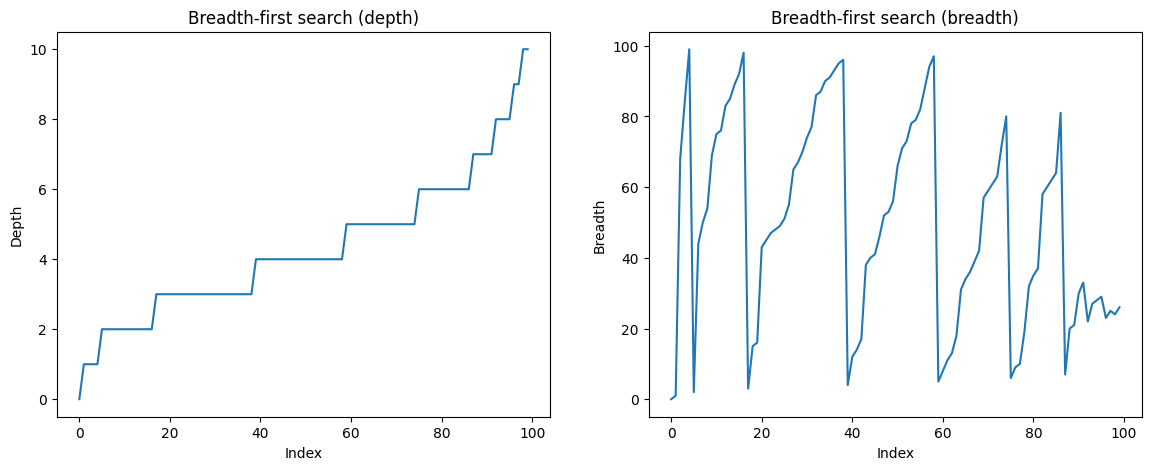

In [110]:
def breadth_first_search(self, start=0):
  visited = [False] * self.n

  rv = []

  queue = []
  queue.append(start)
  visited[start] = True
  while len(queue) > 0:
    a = queue.pop(0)

    rv.append((a, self.depths[a], self.breadths[a]))
    
    for b in self.adjacency_list[a]:
      if not visited[b]:
        queue.append(b)
        visited[b] = True

  return rv

Tree.breadth_first_search = breadth_first_search

y1, y2 = [], []
for node, depth, breadth in tree.breadth_first_search():
  y1.append(depth)
  y2.append(breadth)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Breadth-first search (depth)")
plt.xlabel("Index")
plt.ylabel("Depth")
plt.plot(range(len(y1)), y1)

plt.subplot(1, 2, 2)
plt.title("Breadth-first search (breadth)")
plt.xlabel("Index")
plt.ylabel("Breadth")
plt.plot(range(len(y2)), y2)

plt.show()

The traversal of nodes can be visualized in the form of graphs, where, side-by-side, they offer relevant insight into how the nodes are traversed

In my opinion, the nodes themselves can also be visualized as a 2D plane, or table, where each row represents a certain depth and each column represents a certain breadth

I'll be using both of these comparisons to explain the traversals

Here, breadth-first search is shown as a monotonically increasing depth graph and a zig-zaggy breadth graph. This means:
- Graphs:
  1. The entire breadth of the current depth is searched first (hence the name), as shown on the right
  2. Then, the depth is increased, as shown on the left
- 2D plane:
  1. The traversal searches the entire column (breadth)...
  2. before moving onto the next row (depth)

*Note: this search can be used on all graphs, not just trees! A tree is used just for the sake of demonstration and pertinence to the search problem*

## Depth-first Search (DFS)

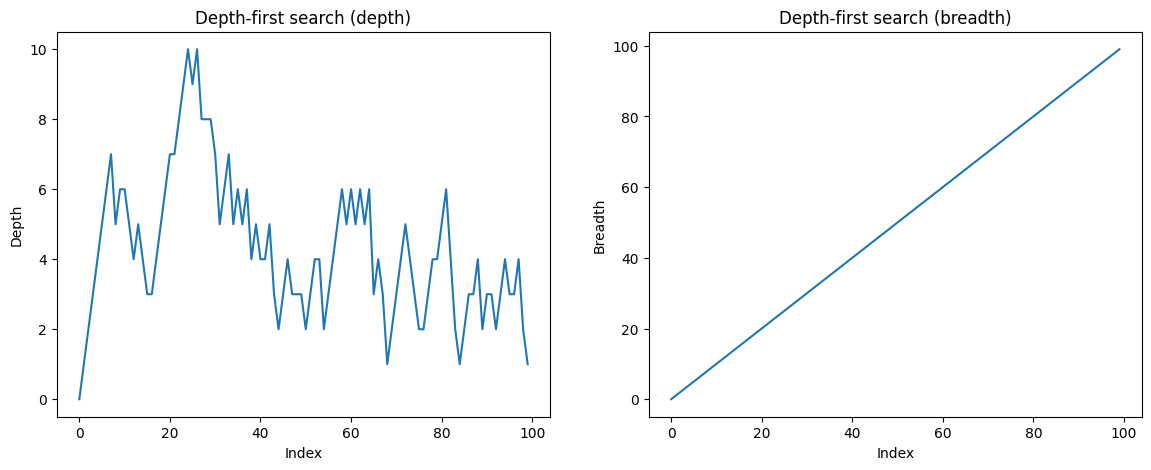

In [111]:
def depth_first_search(self, start=0):
  visited = [False] * self.n
  
  rv = []

  stack = []
  stack.append(start)
  visited[start] = True
  while len(stack) > 0:
    a = stack.pop(-1)

    rv.append((a, self.depths[a], self.breadths[a]))
    
    for b in self.adjacency_list[a][::-1]:
      if not visited[b]:
        stack.append(b)
        visited[b] = True

  return rv

Tree.depth_first_search = depth_first_search

y1, y2 = [], []
for node, depth, breadth in tree.depth_first_search():
  y1.append(depth)
  y2.append(breadth)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Depth-first search (depth)")
plt.xlabel("Index")
plt.ylabel("Depth")
plt.plot(range(len(y1)), y1)

plt.subplot(1, 2, 2)
plt.title("Depth-first search (breadth)")
plt.xlabel("Index")
plt.ylabel("Breadth")
plt.plot(range(len(y2)), y2)

plt.show()

The depth-first search graphs can be understood in a similar way, where the depth graph is now zig-zaggy and the breadth graph is monotonically increasing:
- Graphs:
  1. The entire depth of the breadth depth is searched first, as shown on the left
  2. Then, the breadth is increased, as shown on the right
- 2D plane:
  1. The traversal searches the entire row (depth)...
  2. before moving onto the next column (breadth)

*Note: this search can be used on all graphs, not just trees!*

## Iterative Deepening

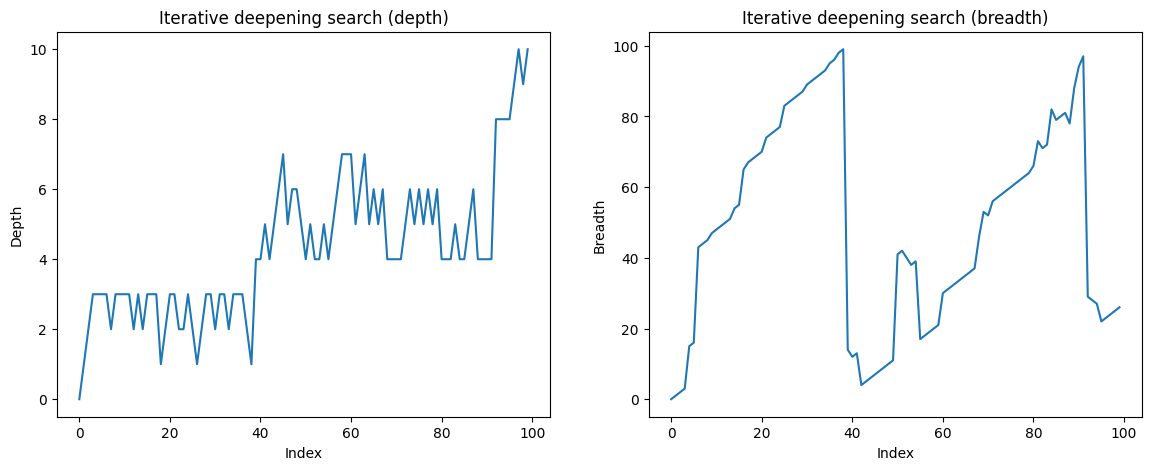

In [112]:
def iterative_deepening(self, block_depth, start=0):
  visited = [False] * self.n
  
  rv = []

  queue = []
  queue.append((0, start))
  visited[start] = True
  while len(queue) > 0:
    coarse_depth, coarse_a = queue.pop(0)

    stack = []
    stack.append((0, coarse_a))

    while len(stack) > 0:
      fine_depth, fine_a = stack.pop(-1)

      rv.append((fine_a, self.depths[fine_a], self.breadths[fine_a]))
    
      for b in self.adjacency_list[fine_a][::-1]:
        if not visited[b]:
          if fine_depth < block_depth:
            stack.append((fine_depth + 1, b))
            visited[b] = True
          else:
            queue.append((coarse_depth + 1, b))
            visited[b] = True

  return rv

Tree.iterative_deepening = iterative_deepening

y1, y2 = [], []
for node, depth, breadth in tree.iterative_deepening(3):
  y1.append(depth)
  y2.append(breadth)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Iterative deepening search (depth)")
plt.xlabel("Index")
plt.ylabel("Depth")
plt.plot(range(len(y1)), y1)

plt.subplot(1, 2, 2)
plt.title("Iterative deepening search (breadth)")
plt.xlabel("Index")
plt.ylabel("Breadth")
plt.plot(range(len(y2)), y2)

plt.show()

Iterative deepening can be used as a combination between depth-first and breadth-first searches

The search is split into two parts, where chunks are a connected group of nodes with *similar* depth and breadth:
1. The first is a "coarse" search, where an entire chunk of nodes is kind of viewed as a single node
2. The second is a "fine" search, where the nodes inside a chunk are traversed normally
  
In addition:
- The type of search within each part of iterative deepening can be any kind, even iterative deepening itself!
  - The idea of using iterative deepening in the coarse or fine search can be used to divide iterative deepening into three, four or any amount of parts, not just two
  - Each search is independent of each other
  - Having depth-first search as both the course and fine searches is not the same as plain depth-first search!

Here, I chose breadth-first search as the coarse search and depth-first search as the fine search

Now, observing the graphs, we see that the left is generally increasing, but kind of zig-zaggy, and the right is a giant zig-zag, but monotonically increasing inside each zig:
- Graphs:
  1. The breadth of chunks is searched before increasing the depth, which is why the shape of the left graph is similar to the left graph of breath-first search and the right graph follows a similar pattern as well
  2. The depth of each node within each chunk is searched before increasing the depth, which results in the depth zig-zagging within each "step" of the depth graph and the monotonically increasing breadth in each zig of the breadth graph, similar to the depth-first search graphs
- 2D plane:
  1. The traversal searches the entire column of chunks (breadth)
  2. Where, inside each chunk, the traversal searches the entire row within the chunk (depth)
  3. before moving onto the next column inside the chunk (breadth)
  4. only then to move to the next row of chunks (depth)

*Note: this search can be used on all graphs, not just trees!*

## Graph Traversal

In [113]:
class DirectedGraph:
  cardinal_directions = [(-1, 0), (0, -1), (1, 0), (0, 1)]

  def __init__(self, n):
    self.n = n

    edges = []
    for i in range(n):
      for j in range(n):
        for di, dj in DirectedGraph.cardinal_directions:
          if i + di < n and j + dj < n and i + di >= 0 and j + dj >= 0:
            cost = math.inf if random.randrange(0, 10) == 0 else 1
            edges.append((self.encode(i, j), self.encode(i + di, j + dj), cost))

    adjacency_list = [[] for i in range(n * n)]
    for a, b, cost in edges:
      adjacency_list[a].append((b, cost))
    
    self.edges = edges
    self.adjacency_list = adjacency_list
  
  def encode(self, i, j):
    return i * self.n + j
  
  def decode(self, x):
    return x // self.n, x % self.n

  def __str__(self):
    costs = [[[-1] * 4 for i in range(self.n)] for j in range(self.n)]

    for i in range(self.n):
      for j in range(self.n):
        for b, cost in self.adjacency_list[self.encode(i, j)]:
          for k in range(len(DirectedGraph.cardinal_directions)):
            di, dj = DirectedGraph.cardinal_directions[k]
            if self.encode(i + di, j + dj) == b:
              costs[i][j][k] = cost

    rv = '┌' + "─────────┬" * (self.n - 1) + "─────────┐"
    for i in range(self.n):
      rv += '\n│'
      for j in range(self.n):
        rv += "   "
        rv += "   " if costs[i][j][0] < 0 else f"{costs[i][j][0]:>3}"
        rv += "   "
        rv += '|'
      rv += "\n│"
      for j in range(self.n):
        rv += "   " if costs[i][j][1] < 0 else f"{costs[i][j][1]:>3}"
        rv += "   "
        rv += "   " if costs[i][j][3] < 0 else f"{costs[i][j][3]:>3}"
        rv += '|'
      rv += "\n│"
      for j in range(self.n):
        rv += "   "
        rv += "   " if costs[i][j][2] < 0 else f"{costs[i][j][2]:>3}"
        rv += "   "
        rv += '|'
      if i == self.n - 1:
        rv += "\n└" + "─────────┴" * (self.n - 1) + "─────────┘"
      else:
        rv += "\n├" + "─────────┼" * (self.n - 1) + "─────────┤"
    
    return rv
  
directed_graph = DirectedGraph(5)
print("*** Directed graph structure ***")
print(directed_graph)

*** Directed graph structure ***
┌─────────┬─────────┬─────────┬─────────┬─────────┐
│         |         |         |         |         |
│        1|  1     1|  1     1|  1     1|inf      |
│     1   |     1   |     1   |   inf   |     1   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     1   |     1   |   inf   |     1   |     1   |
│        1|  1     1|  1     1|  1     1|  1      |
│     1   |     1   |     1   |     1   |     1   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     1   |     1   |     1   |     1   |     1   |
│        1|inf     1|  1     1|  1     1|  1      |
│     1   |     1   |     1   |     1   |     1   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     1   |     1   |     1   |     1   |     1   |
│      inf|  1     1|  1     1|inf     1|  1      |
│     1   |   inf   |     1   |     1   |     1   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│     1   |   inf   |   inf   |     1   |     1   |
│        1|  1     1|  1     1|

Above is a graph. It follows similar rules as the tree, but with a few small differences:
- Edges only have direction if the graph is *directed*
  - Likewise, nodes only have parents or children if the graph is directed
  - And if so, nodes can have multiple parents
- Cycles are allowed, and are specified through the graph's "cyclicity"

Graphs can have certain properties:
- Directedness: if the edges of the tree has direction
- Cyclicity: whether the graph has cycles

As for its comparisons to the search problem:
- There may be more than one way to reach a state, as opposed to a single way (single parent) in the case of a tree
- Describes a more general case
  - Tree traversal can be thought of as a subproblem of graph traversal

In [114]:
class DirectedAcyclicGraph(DirectedGraph):
  def __init__(self, n):
    super().__init__(n)

    edges = []
    for i in range(n):
      for j in range(n):
        for di, dj in DirectedAcyclicGraph.cardinal_directions[2:]:
          if i + di < n and j + dj < n and i + di >= 0 and j + dj >= 0:
            cost = math.inf if random.randrange(0, 10) == 0 else 1
            edges.append((self.encode(i, j), self.encode(i + di, j + dj), cost))

    adjacency_list = [[] for i in range(n * n)]
    for a, b, cost in edges:
      adjacency_list[a].append((b, cost))
    
    self.edges = edges
    self.adjacency_list = adjacency_list
  
directed_acyclic_graph = DirectedAcyclicGraph(5)
print("*** Directed acyclic graph structure ***")
print(directed_acyclic_graph)

*** Directed acyclic graph structure ***
┌─────────┬─────────┬─────────┬─────────┬─────────┐
│         |         |         |         |         |
│        1|        1|        1|        1|         |
│   inf   |     1   |     1   |     1   |     1   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│         |         |         |         |         |
│        1|        1|        1|        1|         |
│     1   |     1   |   inf   |     1   |     1   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│         |         |         |         |         |
│      inf|        1|        1|        1|         |
│     1   |     1   |     1   |   inf   |   inf   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│         |         |         |         |         |
│        1|        1|        1|        1|         |
│     1   |   inf   |     1   |     1   |     1   |
├─────────┼─────────┼─────────┼─────────┼─────────┤
│         |         |         |         |         |
│        1|        1|  

This is a directed *acyclic* graph, it is similar to the directed graph, but guaranteed to not contain cycles.

## Dynamic Programming

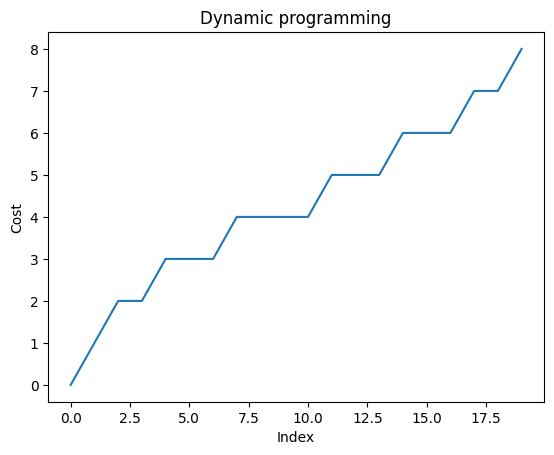

In [115]:
def dynamic_programming(self, start=0):
  costs = [math.inf] * (self.n * self.n)
  
  visits = []

  costs[start] = 0
  for a in range(self.n * self.n):
    if costs[a] != math.inf:
      visits.append((costs[a], a))

      for b, cost in self.adjacency_list[a]:
        costs[b] = min(costs[b], costs[a] + cost)

  visits.sort()

  rv = []
  for cost, node in visits:
    rv.append((node, cost))

  return rv

DirectedAcyclicGraph.dynamic_programming = dynamic_programming

y = []
for node, cost in directed_acyclic_graph.dynamic_programming():
  y.append(cost)

plt.title("Dynamic programming")
plt.xlabel("Index")
plt.ylabel("Cost")
plt.plot(range(len(y)), y)
plt.show()

Dynamic programming is a search algorithm that can be used for directed acyclic graphs.

The principle behind dynamic programming is the re-using of solutions.

Typically, in calculating the shortest path to a node `x`, all nodes leading up to it must also be solved for and considered as parents to `x`. However, this is costly done naively, since some states may be solved multiple, likely many, times. Dynamic programming combats this by keeping track of and reusing the solutions to each node, ensuring every node is only solved once, resulting in a complexity of `O(N)`.

A quirk of this algorithm is that, for one node's shortest path to be solved, all of its parents need to be solved as well, meaning that the graph being performed on must be both directed and acyclic to ensure that a node is never dependent on itself.

## Uniform Cost Search (Dijkstra's Algorithm)

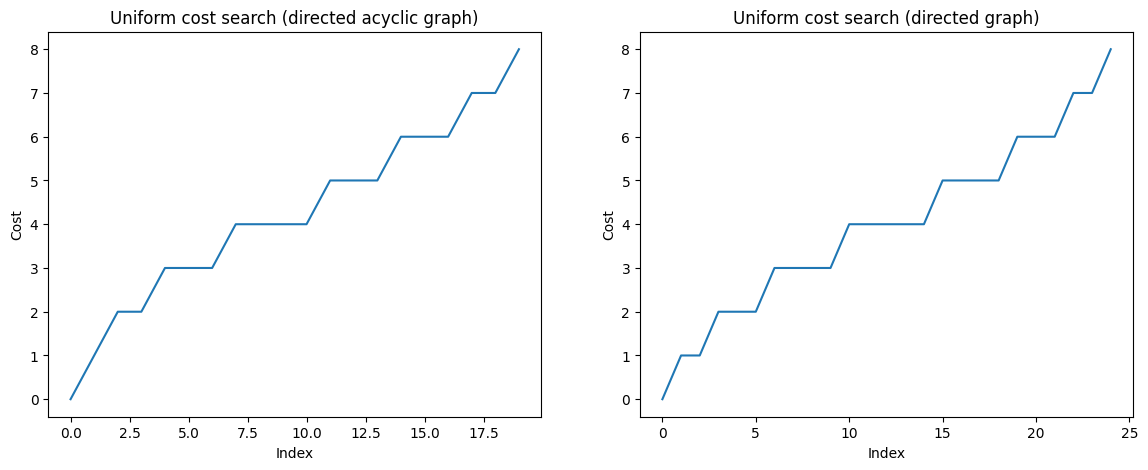

In [116]:
def uniform_cost_search(self, start=0):
  costs = [math.inf] * (self.n * self.n)

  rv = []

  queue = PriorityQueue()
  queue.put((0, start))
  costs[start] = 0
  while not queue.empty():
    total_cost, a = queue.get(0)
    if total_cost != costs[a]:
      continue

    rv.append((a, total_cost))
    
    for b, cost in self.adjacency_list[a]:
      if total_cost + cost < costs[b]:
        queue.put((total_cost + cost, b))
        costs[b] = total_cost + cost

  return rv

DirectedGraph.uniform_cost_search = uniform_cost_search
DirectedAcyclicGraph.uniform_cost_search = uniform_cost_search

y1 = []
for node, cost in directed_acyclic_graph.uniform_cost_search():
  y1.append(cost)

y2 = []
for node, cost in directed_graph.uniform_cost_search():
  y2.append(cost)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Uniform cost search (directed acyclic graph)")
plt.xlabel("Index")
plt.ylabel("Cost")
plt.plot(range(len(y1)), y1)

plt.subplot(1, 2, 2)
plt.title("Uniform cost search (directed graph)")
plt.xlabel("Index")
plt.ylabel("Cost")
plt.plot(range(len(y2)), y2)

plt.show()

Uniform cost search (also known as Dijkstra's algorithm) can be thought of as a generalization of breadth-first search: just like how breadth-first search "radiates" from the starting point in increasing order of depth, uniform cost search is similar in that it too radiates from the starting point in increasing order of depth.

Some accomodating vocabulary for uniform cost search include:
- Explored state: the shortest path has been found for this node
- Frontier state: the shortest path is being presently solved for this node
- Unexplored state: the node has not been considered yet

Of note is how these states are represented in the algorithm: since each edge can be of variable length, the nodes they lead into must first be added to the frontier from the unexplored set. Then, the node in the frontier with the least shortest path, one which cannot be improved further, is removed from the frontier and added to the explored set. While doing this, all edges leading out of this node is traversed and the process is repeated.

## A* Search

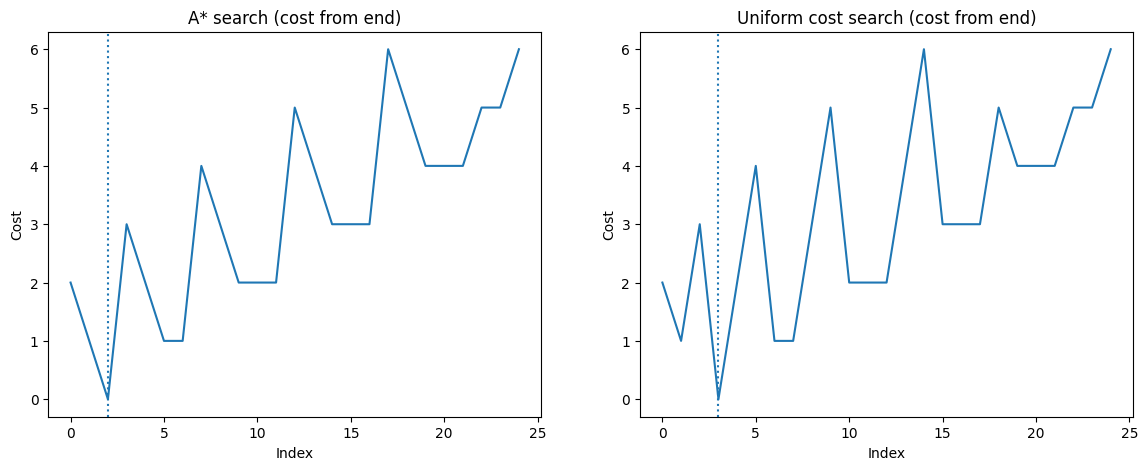

In [117]:
def a_star_search(self, h, start=0):
  costs = [math.inf] * (self.n * self.n)

  rv = []

  queue = PriorityQueue()
  queue.put((0 + h(start), 0, start))
  costs[start] = 0
  while not queue.empty():
    heuristic_cost, total_cost, a = queue.get(0)
    if total_cost != costs[a]:
      continue

    rv.append((a, heuristic_cost))
    
    for b, cost in self.adjacency_list[a]:
      if total_cost + cost < costs[b]:
        queue.put((total_cost + cost + h(b), total_cost + cost, b))
        costs[b] = total_cost + cost

  return rv

DirectedGraph.a_star_search = a_star_search
DirectedAcyclicGraph.a_star_search = a_star_search

start, end = 0, random.randrange(0, directed_graph.n * directed_graph.n)
def h(s):
  i1, j1 = s // directed_graph.n, s % directed_graph.n
  i2, j2 = end // directed_graph.n, end % directed_graph.n
  return abs(i1 - i2) + abs(j1 - j2)

cost_from_end = [0] * (directed_graph.n * directed_graph.n)
for index, info in enumerate(directed_graph.uniform_cost_search(start=end)):
  node, cost = info
  cost_from_end[node] = cost

y1 = []
for node, cost in directed_graph.a_star_search(h, start=start):
  y1.append(cost_from_end[node])

y2 = []
for node, cost in directed_graph.uniform_cost_search(start=start):
  y2.append(cost_from_end[node])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("A* search (cost from end)")
plt.xlabel("Index")
plt.ylabel("Cost")
plt.axvline(x=np.argmin(y1), linestyle="dotted")
plt.plot(range(len(y1)), y1)

plt.subplot(1, 2, 2)
plt.title("Uniform cost search (cost from end)")
plt.xlabel("Index")
plt.ylabel("Cost")
plt.axvline(x=np.argmin(y2), linestyle="dotted")
plt.plot(range(len(y2)), y2)

plt.show()

A* search is an optimization for uniform cost search when provided a specific end state to search for. With the aid of a heuristic `h(s)` added to the cost of each node `s` in the frontier, nodes likely to be closer to the end state (as defined by the heuristic) will be removed from the frontier and solved for sooner. This results in a possible decrease in the number of iterations until the end state is solved, but not always.

While the concept is simple, actually finding a good (valid) heuristic is often tricky. A few terms to keep in mind are:
- Consistency: a heuristic is consistent if `h(s) - h(Succ(s, a)) <= Cost(s, a)`
  - Since uniform cost search, and with it, A* search, relies on the minimum cost node `x` being removed from the frontier during each iteration (when it is impossible to find a shorter path to `x`), if a node's heuristic prevents it from being solved before its children, the search is no longer guaranteed to produce the shortest paths
- Relaxed search problem: a framework for producing consistent heuristics:
  - Satisfied if all `Cost_rel(s, a) <= Cost(s, a)`
  - If we define `h(s) = FutureCost_rel(s)`, the consistency condition is satisfied, as `h(s) - h(Succ(s, a)) <= Cost_rel(s, a)` and `Cost_rel(s, a) <= Cost(s, a)`